In [1]:
import requests
import pandas as pd

url = 'https://earthquake.usgs.gov/fdsnws/event/1/query'

params = {
    'format': 'geojson',
    'starttime': '2014-10-21',
    'endtime': '2015-10-21',
    'minmagnitude': 0,
    'limit': 20000,
}

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()

    earthquakes = []
    for feature in data['features']:
        properties = feature['properties']
        geometry = feature['geometry']

        earthquake_info = {
            'place': properties['place'],
            'magnitude': properties['mag'],
            'time': pd.to_datetime(properties['time'], unit='ms'),
            'latitude': geometry['coordinates'][1],
            'longitude': geometry['coordinates'][0],
            'depth': geometry['coordinates'][2],
        }
        earthquakes.append(earthquake_info)

    df = pd.DataFrame(earthquakes)

    csv_path = '../results/earthquakes_last_10_years.csv'
    df.to_csv(csv_path, index=False)
    print(f"Datos guardados en '{csv_path}'.")

    excel_path = '../results/earthquakes_last_10_years.xlsx'
    df.to_excel(excel_path, index=False)
    print(f"Datos guardados en '{excel_path}'.")

else:
    print(f"Error en la solicitud: {response.status_code}")


Datos guardados en '../results/earthquakes_last_10_years.csv'.
Datos guardados en '../results/earthquakes_last_10_years.xlsx'.


In [2]:
df.head()

,place,magnitude,time,latitude,longitude,depth
0,"1 km E of San Ramon, California",2.04,2015-10-20 23:59:42.530,37.780667,-121.956667,6.40
1,"31 km SE of Caburan, Philippines",4.40,2015-10-20 23:58:24.830,5.743600,125.864600,84.66
2,"21 km NNE of Solok, Indonesia",4.30,2015-10-20 23:57:50.040,-0.610600,100.697700,95.89
3,"37 km SW of Ovalle, Chile",4.50,2015-10-20 23:55:48.340,-30.817600,-71.504500,37.09
4,"74 km ESE of Denali National Park, Alaska",1.30,2015-10-20 23:50:35.718,63.211800,-150.429000,112.70


In [3]:
df.describe()

,magnitude,time,latitude,longitude,depth
count,20000.000000,20000,20000.000000,20000.000000,20000.000000
mean,1.853099,2015-09-21 16:54:04.609779200,36.987066,-107.460007,27.744671
min,0.000000,2015-08-22 15:28:56.020000,-65.465600,-179.986600,-3.390000
25%,0.900000,2015-09-07 12:37:58.076499968,33.835833,-149.249150,5.000000
50%,1.450000,2015-09-20 19:23:34.572499968,38.771749,-119.911350,10.000000
75%,2.400000,2015-10-06 10:24:02.335500032,53.199900,-114.767750,25.500000
max,8.300000,2015-10-20 23:59:42.530000,81.386800,179.987700,651.470000
std,1.325588,NaN,24.285050,72.688176,56.921085


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   place      20000 non-null  object        
 1   magnitude  20000 non-null  float64       
 2   time       20000 non-null  datetime64[ns]
 3   latitude   20000 non-null  float64       
 4   longitude  20000 non-null  float64       
 5   depth      20000 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 937.6+ KB


In [5]:
# Prepare data
df['magnitude'] = df['magnitude'].astype(float)
df['time'] = pd.to_datetime(df['time'])
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)

In [6]:
# Training data
from sklearn.model_selection import train_test_split

X = df[['latitude', 'longitude', 'depth']]
y = df['magnitude']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

params = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [None, 5, 10, 20, 50, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf = RandomForestRegressor(random_state=42)
rs = RandomizedSearchCV(rf, params, n_iter=10, cv=5, n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 10, 20, 50, 100],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200,
                                                         500]},
                   random_state=42)

In [8]:
X2_train, X_val, y2_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
best_model = rs.best_estimator_
best_model.fit(X2_train, y2_train)

RandomForestRegressor(max_depth=50, min_samples_leaf=2, min_samples_split=10,
                      n_estimators=500, random_state=42)

In [10]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = best_model.predict(X_val)
r2 = r2_score(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = mse ** 0.5
print(f"R2: {r2:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

R2: 0.87
MSE: 0.23
RMSE: 0.48


In [11]:
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f"R2: {r2:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

R2: 0.87
MSE: 0.22
RMSE: 0.47


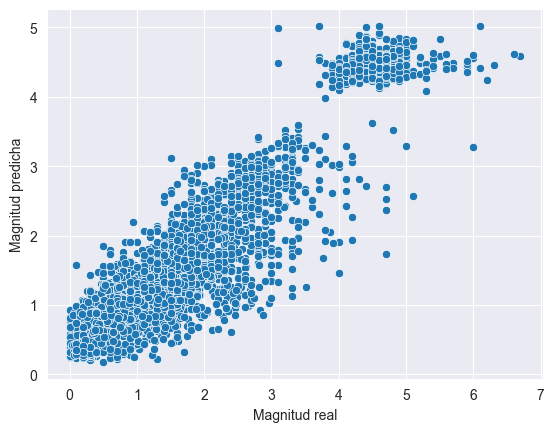

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Magnitud real')
plt.ylabel('Magnitud predicha')
plt.show()

In [13]:
df.columns

Index(['place', 'magnitude', 'time', 'latitude', 'longitude', 'depth', 'year',
       'month', 'day'],
      dtype='object')

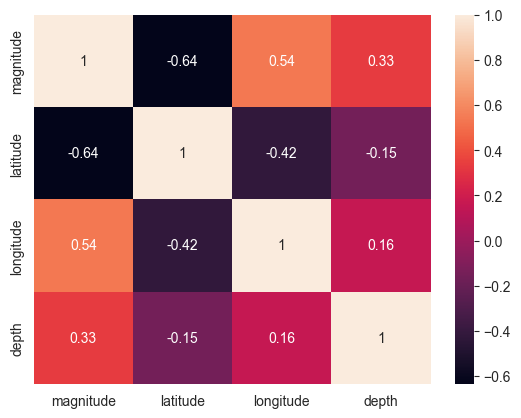

In [14]:
df = df[['magnitude', 'latitude', 'longitude', 'depth']]

corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [15]:
import sweetviz as sv

report = sv.analyze(df)
report.show_html('../results/earthquakes_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report ../results/earthquakes_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [16]:
import gradio as gr

def predict_magnitude(latitude, longitude, depth):
    data = {'latitude': [latitude], 'longitude': [longitude], 'depth': [depth]}
    df = pd.DataFrame(data)
    magnitude = best_model.predict(df)[0]
    return magnitude

latitude = gr.Number(label='Latitud')
longitude = gr.Number(label='Longitud')
depth = gr.Number(label='Profundidad')
output = gr.Number(label='Magnitud')

gr.Interface(fn=predict_magnitude, inputs=[latitude, longitude, depth], outputs=output).launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
